<a href="https://colab.research.google.com/github/duypham01/PDE_Poisson/blob/master/PDE_Poisson(Keras).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import random
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import itertools
import time
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow as tf
import tensorflow.keras
from keras import activations
from tensorflow.keras.layers import Conv2D, Activation, Input, Dense, Add, Lambda, Concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend as K
tf.keras.backend.set_floatx('float32')

Using TensorFlow backend.


In [3]:
def random_data_points(batch_size):
    Points = []
    Boundary_points = []

    for i in range(batch_size):
        Points.append([random.uniform(0, 1), random.uniform(0, 1)])

    for i in range(batch_size):
        random_point = [random.uniform(0, 1), random.uniform(0, 1)]
        random_index = random.randint(0,1)
        random_value = random.randint(0,1)
        random_point[random_index] = random_value
        Boundary_points.append(random_point)
    Points = np.float32(Points)
    Boundary_points = np.float32(Boundary_points)
    return Points, Boundary_points

def random_data_points_test(batch_size):
    Points = []
    for i in range(batch_size):
        Points.append([random.uniform(0, 1), random.uniform(0, 1)])
    Points = np.float32(Points)
    return Points

In [4]:
def laplacian(u, input):
    grads = tape.gradient(u, input)
    ux = grads[0]
    uxx = tape.gradient(ux, input)[0]
    uy = grads[1]
    uyy = tape.gradient(uy, input)[1]
    return uxx + uyy

def boundary_condition(input):
    return 0

# -laplace(u) = f
def right_hand_side(input):
    return 2*(math.pi)**2*math.sin(math.pi*input[0])*math.sin(math.pi*input[1])

def exact_solution(input):
    return math.sin(math.pi*input[0])*math.sin(math.pi*input[1])


In [5]:
def epoch_loss(model, data):
    Point_loss = 0
    Boundary_loss = 0
    Points, Boundary_points = data
    Points = np.array(Points)
    Points = Points.reshape(len(Points),2,1)
    # Points = tf.keras.backend.variable(Points)
    Boundary_points = np.array(Boundary_points)
    Boundary_points = Boundary_points.reshape(len(Boundary_points),2,1)
    # Boundary_points = tf.keras.backend.variable(Boundary_points)
    for Point in Points:
        Point = tf.keras.backend.variable(Point)
        Point_output = model(Point)
        Point_loss += (- laplacian(Point_output, Point) - right_hand_side(Point)) ** 2

    for Boundary_point in Boundary_points:
        Boundary_point = tf.keras.backend.variable(Boundary_point)
        Boundary_point_output = model(Boundary_point)
        Boundary_loss += (Boundary_point_output - boundary_condition(Boundary_point))**2

    Point_loss = Point_loss / len(Points)
    Boundary_loss = Boundary_loss / len(Boundary_points)
    return Point_loss + Boundary_loss

In [6]:
class PDELayerInput(tensorflow.keras.layers.Layer):
    def __init__(self, shape, units=32):
        super(PDELayerInput, self).__init__() 
        self.units = units    # units=M
        self.shape = shape[0]

    def build(self, input_shape):
        input_dim = self.shape
        # if (input_shape):
        #     input_dim = input_shape[0]  # x in R^d (input_dim=d)
        # else:
        #     input_dim = self.shape  # x in R^d (input_dim=d)
        self.W = self.add_weight(
            shape=(self.units, input_dim),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,1), trainable=True,
                                  name='bias',
                                  initializer="random_normal"
        )

    def call(self, inputs):
        return tensorflow.keras.activations.tanh(tf.matmul(self.W, inputs) + self.b)

In [7]:
class PDELayer(tensorflow.keras.layers.Layer):
    def __init__(self, activation, units=32):
        super(PDELayer, self).__init__() 
        self.units = units    # units=M
        self._activation = activations.get(activation)

    def build(self, input_shape):
        input_dim = input_shape[1][0]      # x in R^d (input_dim=d)
        self.Uz = self.add_weight(
            shape=(self.units, input_dim),
            initializer="random_normal",
            trainable=True,
        )
        self.Wz = self.add_weight(
            shape=(self.units, self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.bz = self.add_weight(
            shape=(self.units,1), trainable=True,
                                  name='bias',
                                  initializer="random_normal"
        )
        self.Ug = self.add_weight(
            shape=(self.units, input_dim),
            initializer="random_normal",
            trainable=True,
        )
        self.Wg = self.add_weight(
            shape=(self.units, self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.bg = self.add_weight(
            shape=(self.units,1), trainable=True,
                                  name='bias',
                                  initializer="random_normal"
        )
        self.Ur = self.add_weight(
            shape=(self.units, input_dim),
            initializer="random_normal",
            trainable=True,
        )
        self.Wr = self.add_weight(
            shape=(self.units, self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.br = self.add_weight(
            shape=(self.units,1), trainable=True,
                                  name='bias',
                                  initializer="random_normal"
        )
        self.Uh = self.add_weight(
            shape=(self.units, input_dim),
            initializer="random_normal",
            trainable=True,
        )
        self.Wh = self.add_weight(
            shape=(self.units, self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.bh = self.add_weight(
            shape=(self.units,1), trainable=True,
                                  name='bias',
                                  initializer="random_normal"
        )

    def call(self, inputs):
        S = inputs[0]
        x = inputs[1]
        # print(S)
        # print(x)
        Ones = tensorflow.keras.backend.ones((self.units,1))
        Z = self._activation(tf.matmul(self.Uz, x) + tf.matmul(self.Wz, S) + self.bz)
        G = self._activation(tf.matmul(self.Ug, x) + tf.matmul(self.Wg, S) + self.bg)
        R = self._activation(tf.matmul(self.Ur, x) + tf.matmul(self.Wr, S) + self.br)
        H = self._activation(tf.matmul(self.Uh, x) + tf.matmul(self.Wh, S) + self.bh)

        return (Ones - G)*H + S*Z

In [9]:
class PDELayerOutput(tensorflow.keras.layers.Layer):
    def __init__(self, units=32):
        super(PDELayerOutput, self).__init__() 
        self.units = units    # units=M

    def build(self, input_shape):
        self.W = self.add_weight(
            shape=(1, self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(1,1), trainable=True,
                                  name='bias',
                                  initializer="random_normal"
        )

    def call(self, inputs):
        return tf.matmul(self.W, inputs) + self.b

In [10]:
class PDENet(tensorflow.keras.Model):

    def __init__(self, shape):
        super().__init__()
        self.shape = shape
        # self.input_tensor = tf.(shape=(2,1))
        self.L1 = PDELayerInput(shape=self.shape)
        self.L2 = PDELayer('tanh')
        self.L3 = PDELayer('tanh')
        self.L4 = PDELayerOutput()

    def call(self, inputs):
        # Input_tensor = self.input_tensor(inputs)
        S1 = self.L1(inputs)
        S2 = self.L2([S1, inputs])
        S3 = self.L3([S2, inputs])
        S4 = self.L4(S3)
        return S4

In [11]:
model = PDENet(shape=(2,1))


Start of epoch 0
Time taken: 37.08s
Training loss: 99.4024, L2error: 458.3893

Start of epoch 1
Time taken: 37.34s
Training loss: 94.7621, L2error: 459.6652

Start of epoch 2
Time taken: 36.94s
Training loss: 94.8641, L2error: 474.7151

Start of epoch 3
Time taken: 37.24s
Training loss: 97.7845, L2error: 466.9227

Start of epoch 4
Time taken: 37.23s
Training loss: 99.5152, L2error: 478.2349

Start of epoch 5
Time taken: 36.88s
Training loss: 98.3036, L2error: 478.7250

Start of epoch 6
Time taken: 37.32s
Training loss: 91.4199, L2error: 469.3171

Start of epoch 7
Time taken: 37.63s
Training loss: 100.6969, L2error: 456.0164

Start of epoch 8
Time taken: 37.41s
Training loss: 100.8898, L2error: 497.1496

Start of epoch 9
Time taken: 37.00s
Training loss: 96.7302, L2error: 509.9308

Start of epoch 10
Time taken: 37.67s
Training loss: 93.5958, L2error: 483.7746

Start of epoch 11
Time taken: 37.43s
Training loss: 90.6432, L2error: 484.3814

Start of epoch 12
Time taken: 37.27s
Training l

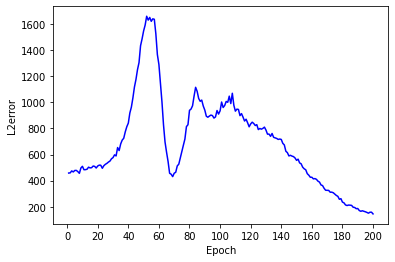

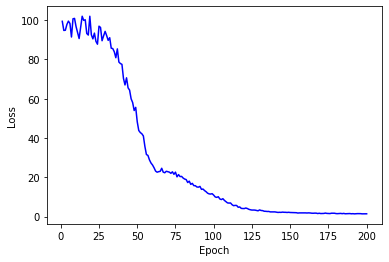

In [13]:
L2errors = []
losses = []
epochs = 200
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
start_training = time.time()
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_epoch_time = time.time()
    
    with tf.GradientTape(persistent=True) as tape:
        data_points = random_data_points(1000)
        loss = epoch_loss(model, data_points)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(
        (grad, var) 
        for (grad, var) in zip(grads, model.trainable_weights) 
        if grad is not None
    )
    # optimizer.apply_gradients(zip(grads, model.trainable_weights))
    print("Time taken: %.2fs" % (time.time() - start_epoch_time))
    losses.append(loss.numpy())
    data_points_test = random_data_points_test(2000)
    data_points_test = np.array(data_points_test)
    data_points_test = data_points_test.reshape(len(data_points_test),2,1)
    L2_error = 0
    for point in data_points_test:
        L2_error += (model(point) - exact_solution(point))**2
    L2errors.append(L2_error)
    print("Training loss: %.4f, L2error: %.4f"
                % (float(loss), float(L2_error))
    )
print("All time training taken: %.2fs" % (time.time() - start_training))
# model.save("my_model")
losses = np.array(losses)
losses = losses.reshape(len(losses))
L2errors = np.array(L2errors)
L2errors = L2errors.reshape(len(L2errors))
print(losses)
x_epochs = [i + 1 for i in range(epochs)]
plt.xticks(np.arange(0, 201, 20))

plt.figure(0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x_epochs, losses, color = 'blue')

plt.figure(1)
plt.xlabel('Epoch')
plt.ylabel('L2error')

plt.plot(x_epochs, L2errors, color = 'blue')